Tài liệu này mang giấy phép Creative Commons Attribution (CC BY).
(c) Nguyễn Ngọc Sáng, Zhukovsky 12/2018.

[@SangVn](https://github.com/SangVn) [@VnCFD](https://vncfdgroup.wordpress.com/)

*Thực hành CFD với Python!*

# Bài 16. Hệ phương trình Euler, bài toán Riemann, phân rã gián đoạn Godunov

In [1]:
%load_ext cython

In [2]:
%%cython
import numpy as np
import matplotlib.pyplot as plt

cdef double g      = 1.4
cdef double gp1    = g+1
cdef double gm1    = g-1
cdef double gp1d2  = (g+1)/2
cdef double gm1d2  = (g-1)/2
cdef double gp1d2g = (g+1)/(2*g)
cdef double gm1d2g = (g-1)/(2*g)
cdef double gm1dgp1 = (g-1)/(g+1)
cdef double gdgm1  = g/(g-1)
cdef double g2dgm1 = g*2/(g-1)
cdef double eps    = 1e-6     #epsilon - sai số 

#Giải bài toán phân rã gián đoạn trong trên từng bề mặt thể tích hữu hạn
def decay_godunov(Pl, Pr):
    cdef double r1 = Pl[0]
    cdef double u1 = Pl[1]
    cdef double p1 = Pl[2]
    cdef double r2 = Pr[0]
    cdef double u2 = Pr[1]
    cdef double p2 = Pr[2]
    
    #vận tốc âm thanh 
    cdef double c1 = (g*p1/r1)**0.5
    cdef double c2 = (g*p2/r2)**0.5

    #phương pháp lặp tìm P
    cdef double P0 = (p1*r2*c2 + p2*r1*c1 + (u1-u2)*r1*c1*r2*c2)/(r1*c1+r2*c2)
    if P0 < eps: P0 = eps
    cdef double z, alpha, phi
    
    cdef int iterations = 50 # max_iteration 
    while (True):
        P = P0 #áp suất P^{n-1}
        if P >= p1: a1 = (r1*(gp1d2*P + gm1d2*p1))**0.5
        else:
            pp = max(eps, P/p1)
            op = 1. - pp**gm1d2g
            if op>=eps: a1 = gm1d2g*r1*c1*(1. - pp)/op
            else: a1 = r1*c1
        if P >= p2: a2 = (r2*(gp1d2*P + gm1d2*p2))**0.5
        else:
            pp = max(eps, P/p2)
            op = 1. - pp**gm1d2g
            if op>=eps: a2 = gm1d2g*r2*c2*(1. - pp)/op
            else: a2 = r2*c2

        z = P/(p1+p2)
        alpha = gm1/(3*g)*(1. - z)/(z**gp1d2g)/(1. - (z**gm1d2g)) - 1.
        if alpha < 0.: alpha = 0.
        phi = (a2*p1 + a1*p2 + a1*a2*(u1 - u2))/(a1+a2)

        P0 = (alpha*P + phi)/(1. + alpha)#tính P^n
        iterations -= 1
        if (abs(P0 - P) < eps) or (not iterations): break
    #kết thúc vòng lặp!
    
    cdef double U = (a1*u1 + a2*u2 + p1 - p2)/(a1 + a2)
    #xét gián đoạn bên trái 
    if P > p1: #nếu là sóng xung kích 
        D1 = u1 - a1/r1
        R1 = r1*a1/(a1-r1*(u1-U))
    else: #nếu là sóng giãn
        D1 = u1 - c1
        c1star = c1 + gm1d2*(u1-U)
        D1star = U - c1star
        R1 = g*P/c1star**2
    #tương tự cho gián đoạn bên phải 
    if P > p2: #nếu là sóng xung kích 
        D2 = u2 + a2/r2
        R2 = r2*a2/(a2 + r2*(u2-U))
    else: #nếu là sóng giãn
        D2 = u2 + c2
        c2star = c2 - gm1d2*(u2-U)
        D2star = U + c2star
        R2 = g*P/c2star**2
        
    #xét cấu hình phân rã xác định nghiệm PStar = (Rstar, Ustar, Pstar)
    #tùy theo vị trí biên i+1/2 nằm trong vùng nào (xem bài 12)

    if D1>0 and D2>0:   #nằm bên trái sóng trái
        Rstar = r1
        Ustar = u1
        Pstar = p1
    elif D1<0 and D2<0: #nằm bên phải sóng phải
        Rstar = r2
        Ustar = u2
        Pstar = p2
    elif D1<0 and D2>0: #nằm giữa hai sóng 
        if U>=0: Rstar = R1 #nằm bên trái gián đoạn tiếp xúc
        else:    Rstar = R2 #nằm bên phải gián đoạn tiếp xúc
        Ustar = U
        Pstar = P
    elif D1<0 and D1star>0: #nằm trong sóng giãn trái
        Ustar = gm1dgp1*u1 + c1/gp1d2
        Pstar = p1*(Ustar/c1)**g2dgm1
        Rstar = g*p1/Ustar**2   
    elif D2>0 and D2star<0: #nằm trong sóng giãn phải 
        Ustar = gm1dgp1*u2 - c2/gp1d2
        Pstar = p2*(Ustar/c2)**g2dgm1
        Rstar = g*p2/Ustar**2
    else:
        print("Error: decay_godunov")

    #vector biến gốc: PStar = [Rstar, Ustar, Pstar]
    FStar = [0, 0, 0] #vector hàm dòng
    FStar[0] = Rstar*Ustar
    FStar[1] = Rstar*Ustar**2 + Pstar
    FStar[2] = Rstar*Ustar**3/2. + Pstar*Ustar*gdgm1
    
    return FStar

#hàm chuyển đổi từ P sang U 
def P2U(P, U):
    r, u, p = P[:, 0], P[:, 1], P[:, 2]
    U[:, 0] = r
    U[:, 1] = r*u
    U[:, 2] = r*u**2/2. + p/gm1
    return

#hàm chuyển đổi từ U về P
def U2P(U, P):
    r, ru, re = U[:, 0], U[:, 1], U[:, 2]
    P[:, 0] = r
    P[:, 1] = u = ru/r
    P[:, 2] = (re - ru*u/2.)*gm1
    return

#tính bước thời gian 
def time_step(P, CFL, dx):
    r, u, p = P[:, 0], P[:, 1], P[:, 2]
    c = np.sqrt(g*p/r) #vận tốc âm thanh 
    u_max = max(abs(u) + c)        
    dt = CFL*dx/u_max
    return dt

#tái cấu trúc nghiệm hằng số từng mảnh - Godunov
def godunov_reconstr(Ps):
    P_left = Ps[:-1].copy()
    P_right = Ps[1:].copy()
    return P_left, P_right

#sơ đồ godunov bậc 1
def godunov_method(Ps, nx, dx, CFL, time_target):
    Us = Ps.copy()
    P2U(Ps, Us)
    Fstar = Ps[:-1].copy()
    time = 0.0
    cdef int i
    while(time < time_target):
        
        #bước 1: tái cấu trúc - reconstruction 
        P_left, P_right = godunov_reconstr(Ps)
        #bước 2: tìm nghiệm phân rã gián đoạn, tính hàm dòng
        for i in range(nx-1): 
            Fstar[i] = decay_godunov(P_left[i], P_right[i])

        #bước 3: tích phân theo thời gian
        dt = time_step(Ps, CFL, dx) 
        if(time+dt > time_target): dt = time + dt-time_target
        time += dt

        Us[1:-1] = Us[1:-1] - dt/dx*(Fstar[1:] - Fstar[:-1]) #tìm biến bảo toàn 
        U2P(Us, Ps) #tìm biến nguyên thủy
        
        #điều kiện biên: outflow
        Ps[0] = Ps[1]
        Ps[-1] = Ps[-2]        
    return

#tìm nghiệm và vẽ đồ thị 
def riemann_solver(Pl, Pr, x, xstar, t_max, CFL):
    nx = len(x)
    dx = x[1] - x[0] #xét trường hợp lưới đều 
    #tạo mảng Ps - matrix (nx, 3)
    Ps = np.zeros((nx, 3))
    Ps[:int(xstar/dx)] = Pl
    Ps[int(xstar/dx):] = Pr
    
    godunov_method(Ps, nx, dx, CFL, t_max)
    
    return Ps

def plot(x, Ps):
    e_godunov   = Ps[:, 2]/(gm1*Ps[:, 0])
    
    f, axarr = plt.subplots(2, 2, figsize=(14,10))
    axarr[0, 0].plot(x, Ps[:, 0])
    axarr[0, 0].set_title('density')
    axarr[0, 1].plot(x, Ps[:, 1])
    axarr[0, 1].set_title('velocity')
    axarr[1, 0].plot(x, Ps[:, 2])
    axarr[1, 0].set_title('pressure')
    axarr[1, 1].plot(x, e_godunov)
    axarr[1, 1].set_title('energy')
    f.subplots_adjust(hspace=0.2)
    plt.legend(['godunov_scheme', 'exact_solution'])
    plt.show()

Kiểm tra kết quả bằng 4 bài test:

In [3]:
#chia lưới đều 
nx = 81
x = np.linspace(0, 1, nx)

#CFL condition
CFL = 0.45

Hãy thay hàm tìm P, tăng nx=1001 và so sánh thời gian tính toán.

In [4]:
#test 1
Pl = [1.0, 0.75, 1.0]
Pr = [0.125, 0.0, 0.1]
xstar = 0.3
t_max = 0.2

%time Ps = riemann_solver(Pl, Pr, x, xstar, t_max, CFL)

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 14.6 ms


In [5]:
#test 2
Pl = [1.0, 0.0, 1000.0]
Pr = [1.0, 0.0, 0.01]
xstar = 0.5
t_max = 0.012
%timeit Ps = riemann_solver(Pl, Pr, x, xstar, t_max, CFL)

10 loops, best of 3: 18.7 ms per loop


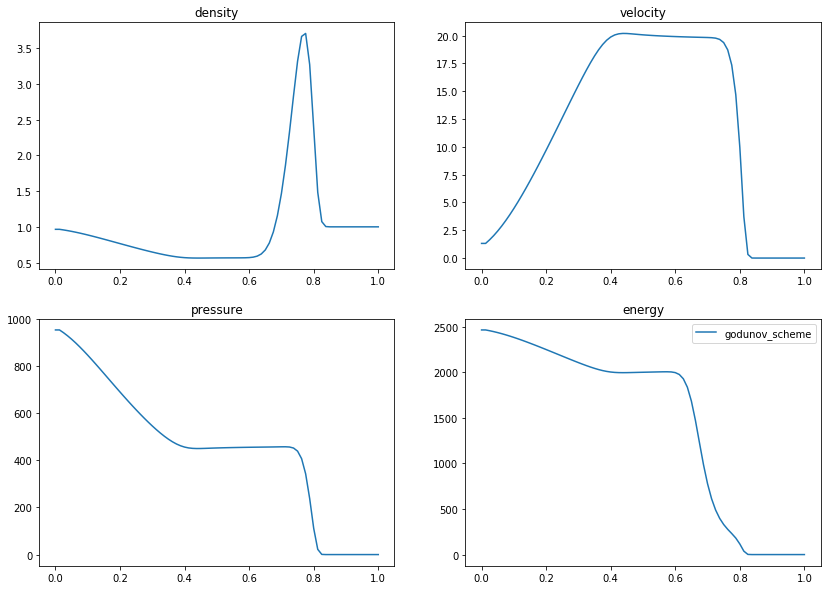

In [6]:
Ps = riemann_solver(Pl, Pr, x, xstar, t_max, CFL)
plot(x, Ps)

In [7]:
#test 3
Pl = [1.0, -0.8, 0.4]
Pr = [1.0, 1.2, 0.4]
xstar = 0.44
t_max = 0.25
%timeit Ps = riemann_solver(Pl, Pr, x, xstar, t_max, CFL)

100 loops, best of 3: 13.9 ms per loop


In [8]:
#test 4
Pl = [1.0, 2.0, 4.0]
Pr = [1.0, -2.0, 4.0]
xstar = 0.5
t_max = 0.04

%timeit Ps = riemann_solver(Pl, Pr, x, xstar, t_max, CFL)

100 loops, best of 3: 4.6 ms per loop


Chúng ta thấy mỗi bài toàn mang một đặc thù riêng. Chúng sẽ được sử dụng để so sánh giữa các phương pháp khác nhau.

Bước cuối cùng, ta tách và lưu code vào ba file trong thư mục lib: **constants.py, decay.py, convert_variables.py, euler_solver.py** để sử dụng cho bài sau.

### [Bài 17. Euler 1D solver: Godunov, MUSCL, WENO5, Runge-Kutta 3](Bai_17.ipynb)